# Lab 6: Random Forest Regression on Malagasy Mammal Traits

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 

In [7]:
dat = pd.read_csv("/courses/EDS232/Data/MamTraitData.csv", encoding="ISO-8859-1", na_values = "-999").rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; carcasses': 'Diet_Other'
})

# drop columns with more than 40% na
dat = dat.loc[:, (dat.isna().sum() / len(dat)) * 100 < 40]


print(f"Final DataFrame shape: {dat.shape}")

Final DataFrame shape: (214, 17)


### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining numeric columns using k-nearest neighbors with `KNNImputer()`. Use the 5 nearest neighbors. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations.Perform and print a check to ensure that there are no more NA values. 

In [8]:
numeric_columns = dat.select_dtypes(include=[np.number]).columns
categorical_columns = dat.select_dtypes(exclude=[np.number]).columns

# Categorical imputation
for col in categorical_columns:
    dat[col] = dat[col].fillna(dat[col].mode()[0])

# Numerical imputation
imputer = KNNImputer(n_neighbors=5)
dat[numeric_columns] = imputer.fit_transform(dat[numeric_columns])

# Check for NAs
print("Categorical columns NA count:")
print(dat[categorical_columns].isna().sum())

print("Numerical columns NA count:")
print(dat[numeric_columns].isna().sum())


Categorical columns NA count:
Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_Seeds            0
Diet_Plants           0
Diet_Other            0
dtype: int64
Numerical columns NA count:
AdultBodyMass      0
HabitatBreadth     0
ActivityCycle      0
ForagingStratum    0
LitterSize         0
Dry                0
Humid              0
Montane            0
Subarid            0
Subhumid           0
dtype: int64


### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [9]:
# Combine 5 climate type variables into column nClimates
dat['nClimates'] = dat[['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid']].sum(axis=1)

# Drop the original columns
dat = dat.drop(['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid'], axis=1)

# Encode categorical variables
le = LabelEncoder()
for col in categorical_columns:
    dat[col] = le.fit_transform(dat[col])

# Set X and y
X = dat.drop('nClimates', axis=1)
y = dat['nClimates']

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=808)

### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

Mean Squared Error: 2.0602


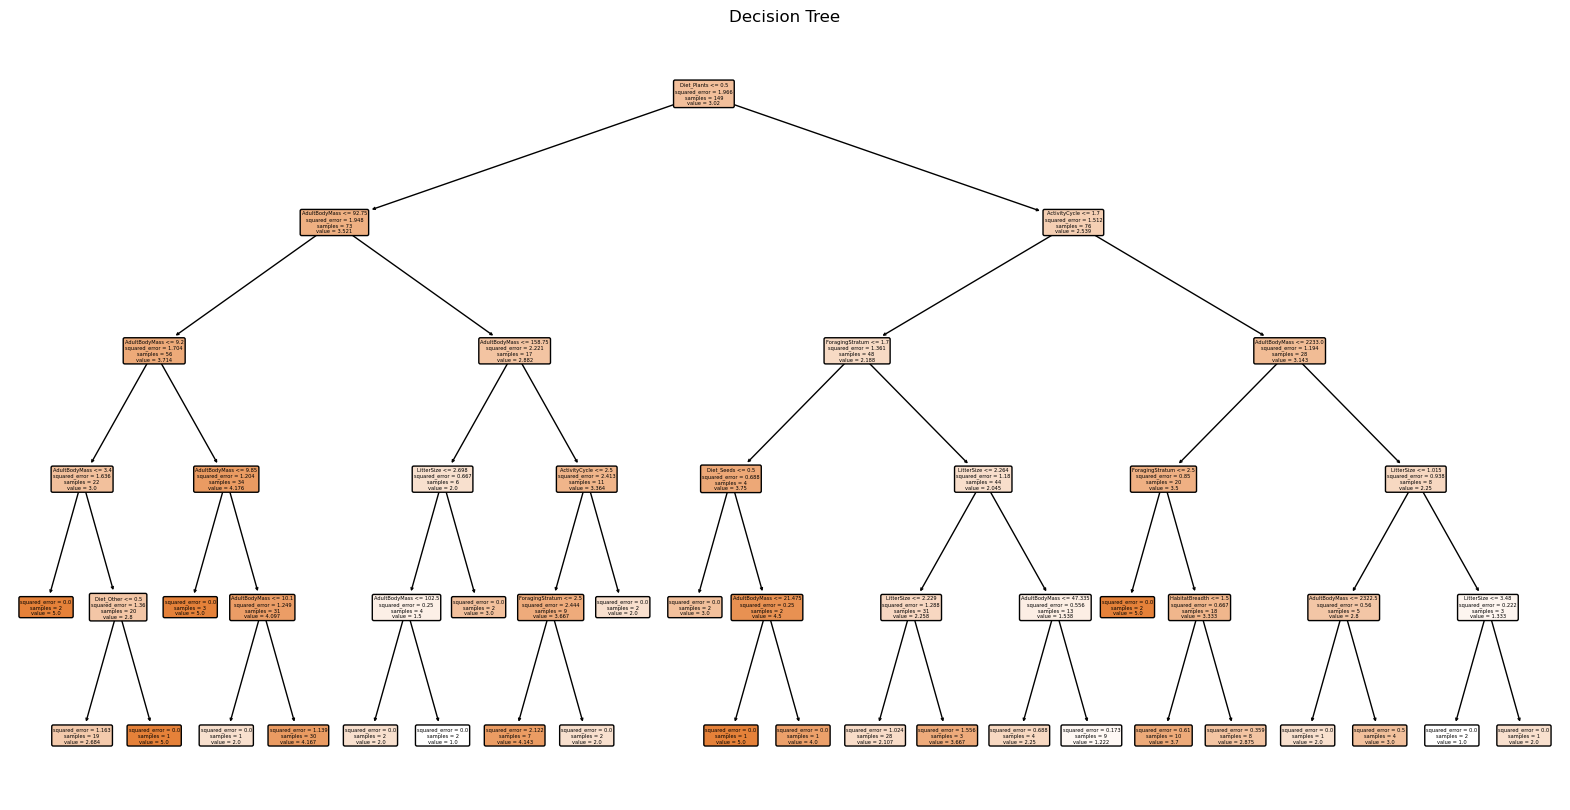

In [10]:
# Train decision tree regressor
dt = DecisionTreeRegressor(max_depth=5, random_state=808)
dt.fit(X_train, y_train)

# Make predictions
y_pred = dt.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

# Visualize the tree
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=X_train.columns, filled=True, rounded=True)
plt.title("Decision Tree")
plt.show()


Based on the way this tree looks, what would you guess the most important variable to be?

I expect diet_plants to be the most important as its the root node.

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [13]:
# Parameter grid
param_grid = {
    'max_features': [int(np.sqrt(X_train.shape[1])), 6, None],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# Set up grid search
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=808),
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,  
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("MSE:", grid_search.best_score_)

# Train best estimator
best_rf = RandomForestRegressor(**grid_search.best_params_, random_state=808)
best_rf.fit(X_train, y_train)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Best parameters: {'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
MSE: -1.573912259925415


RandomForestRegressor(max_depth=5, max_features=3, min_samples_split=5,
                      n_estimators=200, random_state=808)

### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

Best parameters: {'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Mean Squared Error: 1.4362558706826414


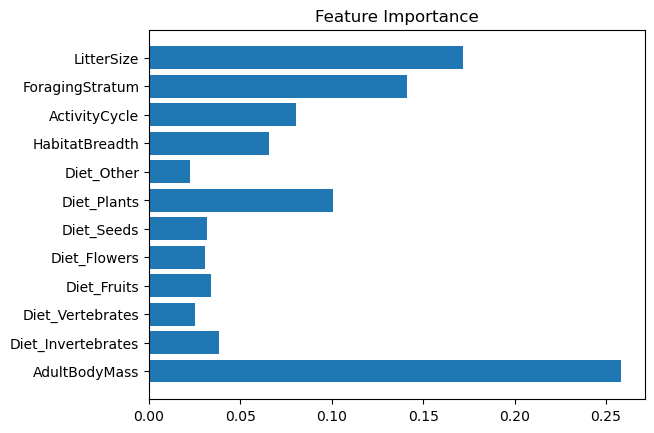

In [12]:
# Predict
y_pred = best_rf.predict(X_test)

# Print best parameters 
print(f"Best parameters: {grid_search.best_params_}")

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Get feature importances
importances = best_rf.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': importances
})

# Create bar plot
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title("Feature Importance")
plt.show()

Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

Looking at the mse, the random forest model had better accuracy than the single decision tree. According to the random forest model, adult body mass has the most influence on species climate adaptability. It is then followed by litter size, foraging stratum, and plant diet.